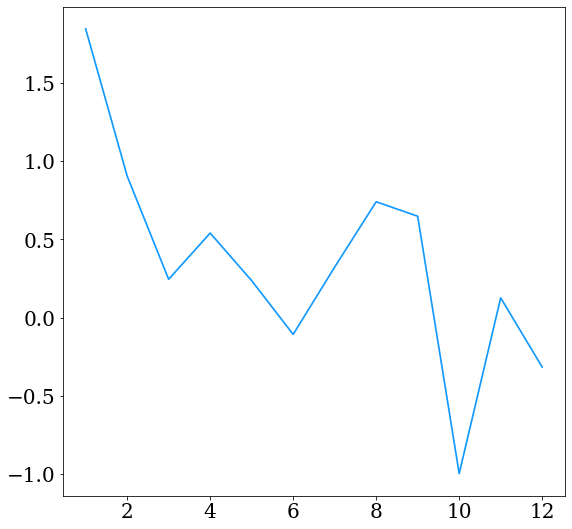

In [1]:
import os.path
import pickle
from pathlib import Path

import autofit as af
from matplotlib import pyplot as plt

from warm_pixels import hst_utilities as ut

data_directory = Path(os.path.abspath("")) / "data"


def load_data(name):
    with open(data_directory / f"{name}.pickle", "r+b") as f:
        return pickle.load(f)


date = load_data("date")
x = load_data("x")
y = load_data("y")
noise = load_data("noise")
n_e = load_data("n_e")
n_bg = load_data("n_bg")
row = load_data("row")

plt.plot(x, y)

In [2]:
from warm_pixels.fit.model import TrailModel


# CCD
rho_q=af.UniformPrior(
    lower_limit=0.0,
    upper_limit=10.0,
)
beta=af.GaussianPrior(
    mean=0.478,
    sigma=0.1,
)
w = af.GaussianPrior(
    mean=84700.0,
    sigma=20000,
)
# Trap species
a = af.UniformPrior(
    lower_limit=0.0,
    upper_limit=1.0,
)
b = af.UniformPrior(
    lower_limit=0.0,
    upper_limit=1.0,
)
c = 1 - (a + b)

# Trap lifetimes before or after the temperature change
if date < ut.date_T_change:
    tau_a_mean = 0.48
    tau_b_mean = 4.86
    tau_c_mean = 20.6
else:
    tau_a_mean = 0.74
    tau_b_mean = 7.70
    tau_c_mean = 37.0

tau_a = af.GaussianPrior(
    mean=tau_a_mean,
    sigma=0.2,
)
tau_b = af.GaussianPrior(
    mean=tau_b_mean,
    sigma=2.0,
)
tau_c = af.GaussianPrior(
    mean=tau_c_mean,
    sigma=10.0,
)

model = af.Model(
    TrailModel,
    rho_q=af.UniformPrior(
        lower_limit=0.0,
        upper_limit=10.0,
    ),
    beta=af.GaussianPrior(
        mean=0.478,
        sigma=0.1,
    ),
    w=w,
    a=a,
    b=b,
    c=c,
    tau_a=tau_a,
    tau_b=tau_b,
    tau_c=tau_c,
)

model.add_assertion(c > 0.0)

In [ ]:
from warm_pixels.fit.analysis import Analysis

"""
We make an instance of the analysis, passing it the data and associated variables.
"""

analysis = Analysis(
    x=x,
    y=y,
    noise=noise,
    n_e=n_e,
    n_bg=n_bg,
    row=row,
)

"""
We make our optimiser which we can configure
"""

dynesty = af.DynestyStatic()

"""
Optimisation is performed by passing the model and the analysis to the fit function
"""

result = dynesty.fit(
    model=model,
    analysis=analysis,
)

2022-10-07 15:13:37,177 - autofit.non_linear.abstract_search - INFO - Creating search
2022-10-07 15:13:37,205 - root - INFO - Starting search
2022-10-07 15:13:37,206 - root - INFO - Saving path info
2022-10-07 15:13:37,207 - root - INFO - Not complete. Starting non-linear search.
2022-10-07 15:13:37,208 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-10-07 15:13:37,330 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


200it [34:26, 248.91s/it, bound: 16 | nc: 81 | ncall: 2529 | eff(%):  7.908 | loglstar:   -inf < -9.002 <    inf | logz: -13.942 +/-  0.403 | dlogz:  3.541 >  0.059] 

In [ ]:
"""
The log likelihood and best parametrisation can be found from the result
"""

print(f"log likelihood = {result.log_likelihood}")

best_trail_model = result.instance

print(f"rho_q = {best_trail_model.rho_q}")